In [1]:
import sys, os, pickle
sys.path.append('/home/om2382/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from torch_tools import *
from wrappers import *
import torch
from torch.optim.lr_scheduler import ExponentialLR

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 3
macro_configs = config_generator()
micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [6]:
### --- define task, generate inputs and outputs ('data') --- ###
T_trial = 100
task = Context_Dependent_Decision_Task(T_trial=T_trial, input_var=0.1, report_cue=True)
N_train = 10000000
N_test = 20000
data = task.gen_data(N_train, N_test, add_dummy_end_point=False)
batched_data = add_batch_dimension_to_data(data, T_trial)

### --- initialize RNN paramters and RNN object --- ###
n_in = task.n_in
n_hidden = 32
n_out = task.n_out

W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))
b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

alpha = 0.1

rnn = Torch_RNN(W_in, W_rec, W_out, b_rec, b_out,
                activation='tanh',
                alpha=alpha)

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)
scheduler = None

In [4]:
checkpoints = train_torch_RNN(rnn, optimizer, batched_data, batch_size=200, n_epochs=2,
                              L2_reg=0.0001, verbose=True, checkpoint_interval=None, scheduler=scheduler)

Epoch 0, Batch 0
Loss 10.14128303527832
Epoch 0, Batch 50
Loss 1.9989968538284302
Epoch 0, Batch 100
Loss 1.9513323307037354
Epoch 0, Batch 150
Loss 1.9493716955184937
Epoch 0, Batch 200
Loss 1.9212180376052856
Epoch 0, Batch 250
Loss 1.8607268333435059
Epoch 0, Batch 300
Loss 1.7148932218551636
Epoch 0, Batch 350
Loss 1.6308718919754028
Epoch 0, Batch 400
Loss 1.4118568897247314
Epoch 0, Batch 450
Loss 1.4223573207855225
Epoch 1, Batch 0
Loss 1.0872645378112793
Epoch 1, Batch 50
Loss 0.8899523615837097
Epoch 1, Batch 100
Loss 0.874048113822937
Epoch 1, Batch 150
Loss 0.8585538268089294
Epoch 1, Batch 200
Loss 0.8426204323768616
Epoch 1, Batch 250
Loss 0.628383219242096
Epoch 1, Batch 300
Loss 0.68345046043396
Epoch 1, Batch 350
Loss 0.7190860509872437
Epoch 1, Batch 400
Loss 0.6745085716247559
Epoch 1, Batch 450
Loss 0.726578414440155


In [5]:
sim = Empty_Simulation()
sim.checkpoints = checkpoints
sim.rnn = checkpoints['final']['rnn']

In [6]:
if True:
    all_args = get_default_args()
    all_args['FP_N'] = 1000
    all_args['FP_same_LR_criterion'] = 8000
    all_args['FP_context'] = np.eye(5)[2]
    #i_final = max(sim.checkpoints.keys())
    checkpoint_1 = sim.checkpoints['final']
    checkpoint_2 = deepcopy(checkpoint_1)

    analyzed_checkpoint_1 = analyze_individual_checkpoint(checkpoint=checkpoint_1,
                                                          task=task,
                                                          data=data,
                                                          all_args=all_args)
    sim.analyzed_checkpoint_1 = analyzed_checkpoint_1
    
    all_args['FP_context'] = np.eye(5)[3]
    analyzed_checkpoint_2 = analyze_individual_checkpoint(checkpoint=checkpoint_2,
                                                          task=task,
                                                          data=data,
                                                          all_args=all_args)
    sim.analyzed_checkpoint_2 = analyzed_checkpoint_2

Analyzing checkpoint 1000...
Analyzing checkpoint 1000...


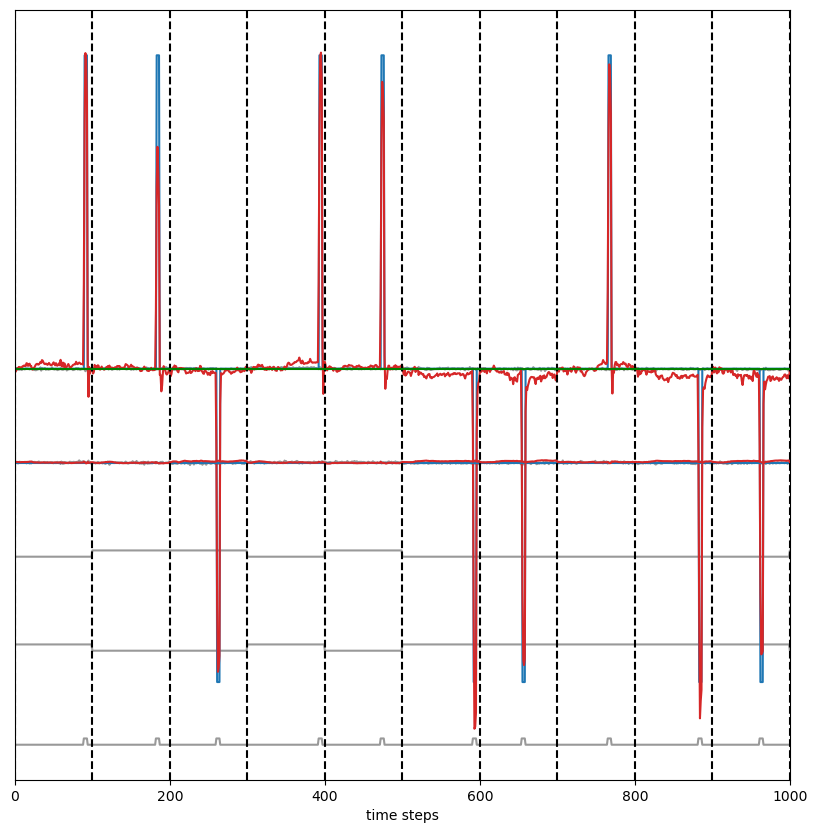

In [15]:
if prototype:
    plot_output_from_checkpoint(sim.checkpoints['final'], data,
                                time_steps_per_trial=T_trial, y_spacing=3,
                                y_scaling=10, x_scaling=0.2, figsize=(10, 10))
    plt.xlim([0, 1000])
    plt.axhline(y=0, color='g')

In [3]:
### --- SAVE RESULTS -- ###
result = {'sim': sim, 'i_seed': i_seed, 'task': task,
          'config': params, 'i_config': i_config, 'i_job': i_job}
with open('saved_runs/example_network_2', 'wb') as f:
    pickle.dump(result, f)

NameError: name 'sim' is not defined

In [4]:
with open('saved_runs/example_network_2', 'rb') as f:
    result = pickle.load(f)

In [8]:
### --- RESULTS FOR FIGURE 5A --- ###

np.random.seed(4)
sim = result['sim']
task = result['task']
test_sim = Simulation(sim.checkpoints['final']['rnn'])
mode = 'test'
task.tonic_report = False
data = task.gen_data(0, 100, add_dummy_end_point=False)
test_sim.run(data, mode=mode, monitors=['rnn.loss_', 'rnn.y_hat'], verbose=False)

In [9]:
probe_colors = ['#000080', '#353a9c', '#6b75b9', '#a0b0d5', '#d6ebf2',
                '#ffdae0', '#e2a3a8', '#c56d70', '#a83638', '#8b0000']

(0.0, 100.0, -1.0, 1.0)

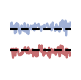

In [10]:
### --- FIGURE 5A PART I --- ###

cm = 1/2.54
fig = plt.figure(figsize=(2*cm, 2*cm))
plt.plot(data['test']['X'][:,0] + 0.35, color=probe_colors[3])
plt.axhline(y=0.35, linestyle='--', color='k')
plt.plot(data['test']['X'][:,1] - 0.35, color=probe_colors[7])
plt.axhline(y=-0.35, linestyle='--', color='k')
plt.ylim([-1, 1])
plt.xlim([0, 100])
#plt.plot(data['test']['Y'][:,0], color='C3')
#plt.plot(test_sim.mons['rnn.y_hat'][:,0], color='C2')
plt.axis('off')
#for t in range(0, 1000, 100):
#    plt.axvline(x=t, color='k', linestyle='--')
#fig.savefig('figs/fig5a_evidence_2.pdf', format='pdf')

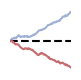

In [19]:
### --- FIGURE 5A PART II --- ###

cm = 1/2.54
fig = plt.figure(figsize=(2*cm, 2*cm))
plt.plot(0.025*np.cumsum(data['test']['X'][:,0]), color=probe_colors[3])
plt.axhline(y=0, linestyle='--', color='k')
plt.plot(0.025*np.cumsum(data['test']['X'][:,1]), color=probe_colors[7])
#plt.axhline(y=-0.35, linestyle='--', color='k')
#plt.ylim([-1, 1])
plt.xlim([0, 100])
plt.axis('off')
fig.savefig('figs/fig5a_CDI_label_2.pdf', format='pdf')

In [13]:
data['test']['X'][:100,:].mean(0)

array([ 0.05964717, -0.05323911,  1.        ,  0.        ,  0.05      ])

(0.0, 100.0, -0.03808997993073525, 0.3160995228538445)

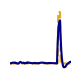

In [14]:
### --- FIGURE 5A PART II --- ###

cm = 1/2.54
fig = plt.figure(figsize=(2*cm, 2*cm))
#plt.plot(0.3*data['test']['X'][:,4] - 0.4, color='C3')
plt.plot(0.3*data['test']['Y'][:,0], color='#DDAB2C', linestyle='--')
plt.plot(0.3*test_sim.mons['rnn.y_hat'][:,0], color=probe_colors[0])
#plt.ylim([-1, 1])
plt.xlim([0, 100])
plt.axis('off')
#fig.savefig('figs/fig_5a_report.pdf', format='pdf')

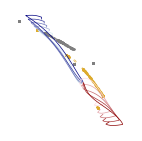

In [15]:
### --- FIGURE 5B PART I --- ###

rnn = sim.checkpoints['final']['rnn']
probe_sim = Simulation(rnn)
probe_sim.run(data,
              mode='probe',
              monitors=['rnn.loss_', 'rnn.y_hat', 'rnn.a'],
              verbose=False)

#proj = np.linalg.qr(np.random.normal(0, 1, (rnn.n_h, rnn.n_h)))[0][:,:2]
#U, S, VT = np.linalg.svd(probe_sim.mons['rnn.a'])
#proj = VT[:,:2]

FP = np.concatenate([sim.analyzed_checkpoint_1['fixed_points'],
                     sim.analyzed_checkpoint_2['fixed_points']], axis=0)
U, S, VT = np.linalg.svd(FP)
proj = VT[:,:2]

fig = plt.figure(figsize=(4*cm, 4*cm))
fp_1 = sim.analyzed_checkpoint_1['fixed_points'].dot(proj)
fp_2 = sim.analyzed_checkpoint_2['fixed_points'].dot(proj)
plt.plot(fp_1[:,0], fp_1[:,1], '.', color='#DDAB2C', markersize=0.6)
plt.plot(fp_2[:,0], fp_2[:,1], '.', color='C7', markersize=1)
plt.axis('off')
plt.axis('equal')

probe_colors = ['#00cb33','#00d826','#00e519','#00f20c','#00ff00','#ffff00','#fff200','#ffe500','#ffd800','#ffd800',
                '#000099','#1e1ead','#3d3dc1','#5b5bd6','#9999ff','#ff9999','#ff7a7a','#ff5b5b','#ff3d3d','#ff0000']
probe_colors = ['#000080', '#353a9c', '#6b75b9', '#a0b0d5', '#d6ebf2',
                '#ffdae0', '#e2a3a8', '#c56d70', '#a83638', '#8b0000']
n_probes = 20
T_per_sample = 100
for i_probe in [4,3,2,1,0,5,6,7,8,9]:
    #col = ('{}'.format(0.4 + 0.4 * i_probe / n_probes))
    col = probe_colors[i_probe]
    #A = np.roll(probe_sim.mons['rnn.a'], -1, axis=0)
    A = probe_sim.mons['rnn.a']
    rnn_activity = A[i_probe*T_per_sample:(i_probe+1)*T_per_sample]
    probes = rnn_activity.dot(proj)
    plt.plot(probes[:,0], probes[:,1], color=col, linewidth=0.5)
#fig.savefig('figs/fig5b_ctx0.pdf', format='pdf')

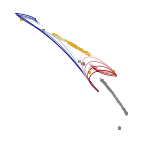

In [16]:
fig = plt.figure(figsize=(4*cm, 4*cm))
fp_1 = sim.analyzed_checkpoint_1['fixed_points'].dot(proj)
fp_2 = sim.analyzed_checkpoint_2['fixed_points'].dot(proj)
plt.plot(fp_1[:,0], fp_1[:,1], '.', color='C7', markersize=0.6)
plt.plot(fp_2[:,0], fp_2[:,1], '.', color='#DDAB2C', markersize=1)
plt.axis('off')
plt.axis('equal')

n_probes = 20
T_per_sample = 100
for i_probe in [14,13,12,11,10,15,16,17,18,19]:
    #col = ('{}'.format(0.4 + 0.4 * i_probe / n_probes))
    col = probe_colors[i_probe - 10]
    #A = np.roll(probe_sim.mons['rnn.a'], -1, axis=0)
    A = probe_sim.mons['rnn.a']
    rnn_activity = A[i_probe*T_per_sample:(i_probe+1)*T_per_sample]
    probes = rnn_activity.dot(proj)
    plt.plot(probes[:,0], probes[:,1], color=col, linewidth=0.5)
#fig.savefig('figs/fig5b_ctx1.pdf', format='pdf')

In [18]:
sim.analyzed_checkpoint_1['nodes'].shape

(2, 32)

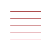

In [30]:
fig = plt.figure(figsize=(1*cm, 1*cm))
for i_probe in range(5,10):
    col = probe_colors[i_probe]
    plt.axhline(y=0.5*i_probe, linewidth=0.5, color=col)
    plt.axis('off')
fig.savefig('figs/color_legend_2.pdf', format='pdf')

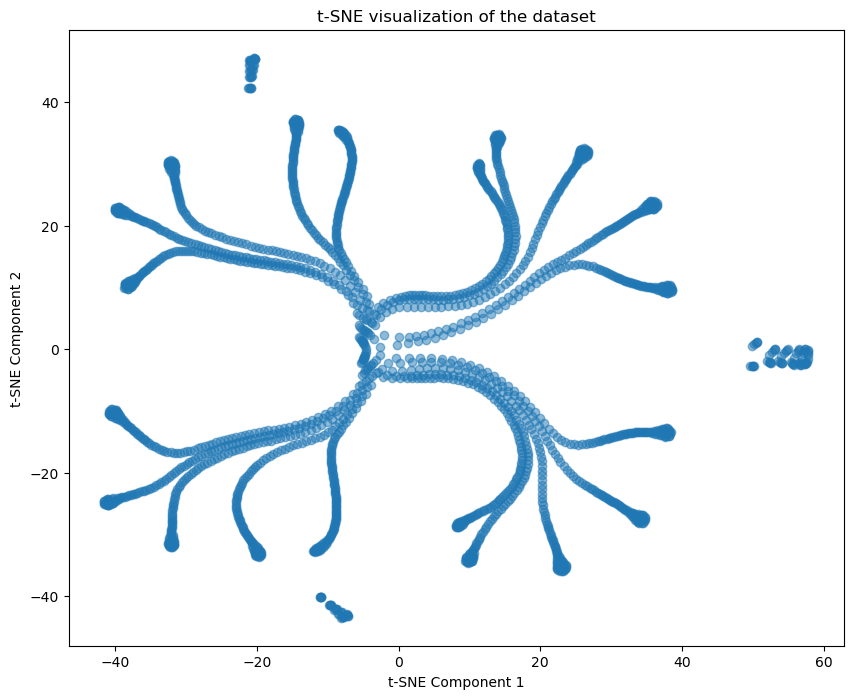

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming you have a dataset called 'data' with shape (n_samples, n_features)
data = np.concatenate([A,
                       sim.analyzed_checkpoint_1['fixed_points'],
                       sim.analyzed_checkpoint_2['fixed_points']], axis=0)
data = A

# Apply t-SNE transformation
tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(data)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], alpha=0.5)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE visualization of the dataset")
plt.show()


In [ ]:
rnn = sim.checkpoints['final']['rnn']
proj = np.linalg.qr(np.random.normal(0, 1, (rnn.n_h, rnn.n_h)))[0][:,:2]
fp_1 = sim.analyzed_checkpoint_1['fixed_points'].dot(proj)
fp_2 = sim.analyzed_checkpoint_2['fixed_points'].dot(proj)
plt.plot(fp_1[:,0], fp_1[:,1], '.')
plt.plot(fp_2[:,0], fp_2[:,1], '.')
plt.axis('off')
plt.axis('equal')